In [1]:
import numpy as np

class ScratchKMeans():
    """
    K-means scratch implementation

    Parameters
    ----------
    n_clusters : int
      Number of clusters
    n_init : int
      How many times to change the initial value of the center point for calculation
    max_iter : int
      Maximum number of iterations in one calculation
    tol : float
      Margin of error between the center point and the center of gravity, which is the reference for ending the iteration
    verbose : bool
      True to output the learning process
    """
    def __init__(self, n_clusters=8, n_init=10, max_iter=300, tol=1e-4, verbose=False):
        # Record hyperparameters as attributes
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.cluster_centers_ = None
        self.labels_ = None
        
    def _initialize_centroids(self, X):
        """
        Randomly select n_clusters data points as initial centroids
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Input data
            
        Returns
        -------
        centroids : ndarray, shape (n_clusters, n_features)
            Initial centroids
        """
        n_samples = X.shape[0]
        random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        centroids = X[random_indices]
        return centroids
    
    def fit(self, X):
        """
        Calculate clustering by K-means
        
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        """
        best_inertia = np.inf
        best_centroids = None
        best_labels = None
        
        for init in range(self.n_init):
            if self.verbose:
                print(f"Initialization {init + 1}/{self.n_init}")
                
            # Initialize centroids
            centroids = self._initialize_centroids(X)
            
            for iteration in range(self.max_iter):
                # Assign each sample to the nearest centroid
                distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
                labels = np.argmin(distances, axis=0)
                
                # Update centroids
                new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(self.n_clusters)])
                
                # Check for convergence
                centroid_shift = np.sqrt(((new_centroids - centroids)**2).sum(axis=1)).max()
                if centroid_shift < self.tol:
                    if self.verbose:
                        print(f"Converged at iteration {iteration + 1}")
                    break
                    
                centroids = new_centroids
                
                if self.verbose and (iteration + 1) % 10 == 0:
                    print(f"Iteration {iteration + 1}, max centroid shift: {centroid_shift:.4f}")
            
            # Calculate inertia (sum of squared distances to nearest centroid)
            inertia = np.sum((X - centroids[labels])**2)
            
            # Keep track of best solution
            if inertia < best_inertia:
                best_inertia = inertia
                best_centroids = centroids
                best_labels = labels
                
        self.cluster_centers_ = best_centroids
        self.labels_ = best_labels
        self.inertia_ = best_inertia
        
        return self
    
    def predict(self, X):
        """
        Calculate which cluster the input data belongs to
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Input data
            
        Returns
        -------
        labels : ndarray, shape (n_samples,)
            Index of the cluster each sample belongs to
        """
        if self.cluster_centers_ is None:
            raise ValueError("Model has not been fitted yet.")
            
        distances = np.sqrt(((X - self.cluster_centers_[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)
        return labels

In [ ]:
#prob 2

import numpy as np

class ScratchKMeans():
    """
    K-means scratch implementation

    Parameters
    ----------
    n_clusters : int
      Number of clusters
    n_init : int
      How many times to change the initial value of the center point for calculation
    max_iter : int
      Maximum number of iterations in one calculation
    tol : float
      Margin of error between the center point and the center of gravity, which is the reference for ending the iteration
    verbose : bool
      True to output the learning process
    """
    def __init__(self, n_clusters=8, n_init=10, max_iter=300, tol=1e-4, verbose=False):
        # Record hyperparameters as attributes
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None  # This will store the best SSE found
        
    def _initialize_centroids(self, X):
        """
        Randomly select n_clusters data points as initial centroids
        """
        n_samples = X.shape[0]
        random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        centroids = X[random_indices]
        return centroids
    
    def _calculate_sse(self, X, centroids, labels):
        """
        Calculate Sum of Squared Errors (SSE)
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Input data
        centroids : ndarray, shape (n_clusters, n_features)
            Current cluster centers
        labels : ndarray, shape (n_samples,)
            Current cluster assignments
            
        Returns
        -------
        sse : float
            Sum of squared errors
        """
        sse = 0.0
        for k in range(self.n_clusters):
            # Get all points assigned to cluster k
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                # Calculate squared distance from each point to its centroid
                distances = np.sum((cluster_points - centroids[k])**2, axis=1)
                sse += np.sum(distances)
        return sse
    
    def _assign_clusters(self, X, centroids):
        """
        Assign each data point to the nearest centroid
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Input data
        centroids : ndarray, shape (n_clusters, n_features)
            Current cluster centers
            
        Returns
        -------
        labels : ndarray, shape (n_samples,)
            Cluster assignments
        """
        # Calculate distances from each point to each centroid
        distances = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            distances[:, k] = np.sum((X - centroids[k])**2, axis=1)
        
        # Assign to nearest centroid
        labels = np.argmin(distances, axis=1)
        return labels
    
    def _update_centroids(self, X, labels):
        """
        Update centroids to be the mean of their assigned points
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Input data
        labels : ndarray, shape (n_samples,)
            Current cluster assignments
            
        Returns
        -------
        new_centroids : ndarray, shape (n_clusters, n_features)
            Updated cluster centers
        """
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            # Get all points assigned to cluster k
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                new_centroids[k] = np.mean(cluster_points, axis=0)
            else:
                # If no points assigned to cluster, keep previous centroid
                new_centroids[k] = self.cluster_centers_[k] if hasattr(self, 'cluster_centers_') else np.zeros(X.shape[1])
        return new_centroids
    
    def fit(self, X):
        """
        Calculate clustering by K-means
        """
        best_sse = np.inf
        best_centroids = None
        best_labels = None
        
        for init in range(self.n_init):
            if self.verbose:
                print(f"\nInitialization {init + 1}/{self.n_init}")
                
            # Initialize centroids
            centroids = self._initialize_centroids(X)
            
            for iteration in range(self.max_iter):
                #  Assign clusters (E-step)
                labels = self._assign_clusters(X, centroids)
                
                # Update centroids (M-step)
                new_centroids = self._update_centroids(X, labels)
                
                # Calculate SSE for current iteration
                current_sse = self._calculate_sse(X, centroids, labels)
                if self.verbose:
                    print(f"Iteration {iteration + 1}: SSE = {current_sse:.4f}")
                
                #  Check for convergence
                centroid_shift = np.max(np.sqrt(np.sum((new_centroids - centroids)**2, axis=1)))
                if centroid_shift < self.tol:
                    if self.verbose:
                        print(f"Converged after {iteration + 1} iterations")
                    break
                    
                centroids = new_centroids
            
            # Calculate final SSE for this initialization
            final_sse = self._calculate_sse(X, centroids, labels)
            if self.verbose:
                print(f"Final SSE for initialization {init + 1}: {final_sse:.4f}")
            
            # Keep track of best solution
            if final_sse < best_sse:
                best_sse = final_sse
                best_centroids = centroids
                best_labels = labels
        
        # Store the best results
        self.cluster_centers_ = best_centroids
        self.labels_ = best_labels
        self.inertia_ = best_sse  # scikit-learn compatible attribute name for SSE
        
        return self
    
    def predict(self, X):
        """
        Predict the closest cluster each sample in X belongs to.
        """
        if self.cluster_centers_ is None:
            raise ValueError("Model has not been fitted yet.")
        return self._assign_clusters(X, self.cluster_centers_)

In [ ]:
#Problem 3

import numpy as np

class ScratchKMeans():
    """
    K-means scratch implementation with optimized cluster assignment
    """
    def __init__(self, n_clusters=8, n_init=10, max_iter=300, tol=1e-4, verbose=False):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None
        
    def _initialize_centroids(self, X):
        """Randomly select initial centroids from data points"""
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[indices]
    
    def _assign_to_clusters(self, X, centroids):
        """
        Assign each data point to the nearest centroid using Euclidean distance
        
        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Input data
        centroids : ndarray of shape (n_clusters, n_features)
            Current cluster centers
            
        Returns
        -------
        labels : ndarray of shape (n_samples,)
            Cluster assignments (0 to n_clusters-1)
        """
        # Calculate distances from each point to each centroid
        distances = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            # Using np.linalg.norm for Euclidean distance (L2 norm)
            distances[:, k] = np.linalg.norm(X - centroids[k], axis=1)
        
        # Assign to nearest centroid (minimum distance)
        labels = np.argmin(distances, axis=1)
        return labels
    
    def _update_centroids(self, X, labels):
        """Update centroids as mean of assigned points"""
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                new_centroids[k] = np.mean(cluster_points, axis=0)
            else:
                # Handle empty clusters by keeping previous centroid
                new_centroids[k] = self.cluster_centers_[k] if hasattr(self, 'cluster_centers_') else X[np.random.randint(X.shape[0])]
        return new_centroids
    
    def fit(self, X):
        """Perform K-means clustering"""
        best_inertia = np.inf
        best_centroids = None
        best_labels = None
        
        for init in range(self.n_init):
            if self.verbose:
                print(f"\nInitialization {init+1}/{self.n_init}")
            
            #  Initialize centroids
            centroids = self._initialize_centroids(X)
            
            for iteration in range(self.max_iter):
                #  Assign points to nearest centroid (E-step)
                labels = self._assign_to_clusters(X, centroids)
                
                #  Update centroids (M-step)
                new_centroids = self._update_centroids(X, labels)
                
                # Check convergence
                centroid_shift = np.max(np.linalg.norm(new_centroids - centroids, axis=1))
                if centroid_shift < self.tol:
                    if self.verbose:
                        print(f"Converged at iteration {iteration+1}")
                    break
                    
                centroids = new_centroids
            
            # Calculate inertia (SSE) for this run
            inertia = self._calculate_inertia(X, centroids, labels)
            if inertia < best_inertia:
                best_inertia = inertia
                best_centroids = centroids
                best_labels = labels
        
        self.cluster_centers_ = best_centroids
        self.labels_ = best_labels
        self.inertia_ = best_inertia
        return self
    
    def _calculate_inertia(self, X, centroids, labels):
        """Calculate sum of squared distances to nearest centroid"""
        inertia = 0.0
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                inertia += np.sum(np.linalg.norm(cluster_points - centroids[k], axis=1)**2)
        return inertia
    
    def predict(self, X):
        """Predict cluster labels for new data"""
        if self.cluster_centers_ is None:
            raise ValueError("Model not fitted yet")
        return self._assign_to_clusters(X, self.cluster_centers_)

In [ ]:
#Problem 4

import numpy as np

class ScratchKMeans():
    """
    K-means scratch implementation with complete centroid movement
    """
    def __init__(self, n_clusters=8, n_init=10, max_iter=300, tol=1e-4, verbose=False):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None
        
    def _initialize_centroids(self, X):
        """Randomly select initial centroids from data points"""
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[indices]
    
    def _assign_to_clusters(self, X, centroids):
        """Assign each data point to the nearest centroid"""
        distances = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            distances[:, k] = np.linalg.norm(X - centroids[k], axis=1)
        return np.argmin(distances, axis=1)
    
    def _move_centroids(self, X, labels):
        """
        Move each centroid to the mean of its assigned points
        
        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Input data
        labels : ndarray of shape (n_samples,)
            Current cluster assignments
            
        Returns
        -------
        new_centroids : ndarray of shape (n_clusters, n_features)
            Updated cluster centers
        """
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))
        
        for k in range(self.n_clusters):
            # Get all points assigned to current cluster
            cluster_points = X[labels == k]
            
            if len(cluster_points) > 0:
                # Calculate mean of points in cluster (the new centroid)
                new_centroids[k] = np.mean(cluster_points, axis=0)
            else:
                # Handle empty clusters by reinitializing randomly
                if self.verbose:
                    print(f"Cluster {k} became empty. Reinitializing.")
                new_centroids[k] = X[np.random.randint(X.shape[0])]
                
        return new_centroids
    
    def fit(self, X):
        """Perform K-means clustering"""
        best_inertia = np.inf
        best_centroids = None
        best_labels = None
        
        for init in range(self.n_init):
            if self.verbose:
                print(f"\nInitialization {init+1}/{self.n_init}")
            
            #  Initialize centroids
            centroids = self._initialize_centroids(X)
            
            for iteration in range(self.max_iter):
                #  Assign points to nearest centroid (E-step)
                labels = self._assign_to_clusters(X, centroids)
                
                #  Move centroids to cluster means (M-step)
                new_centroids = self._move_centroids(X, labels)
                
                # Check convergence
                centroid_shift = np.max(np.linalg.norm(new_centroids - centroids, axis=1))
                if centroid_shift < self.tol:
                    if self.verbose:
                        print(f"Converged at iteration {iteration+1}")
                    break
                    
                centroids = new_centroids
            
            # Calculate inertia (SSE) for this run
            inertia = self._calculate_inertia(X, centroids, labels)
            if inertia < best_inertia:
                best_inertia = inertia
                best_centroids = centroids
                best_labels = labels
        
        self.cluster_centers_ = best_centroids
        self.labels_ = best_labels
        self.inertia_ = best_inertia
        return self
    
    def _calculate_inertia(self, X, centroids, labels):
        """Calculate sum of squared distances to nearest centroid"""
        inertia = 0.0
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                inertia += np.sum(np.linalg.norm(cluster_points - centroids[k], axis=1)**2)
        return inertia
    
    def predict(self, X):
        """Predict cluster labels for new data"""
        if self.cluster_centers_ is None:
            raise ValueError("Model not fitted yet")
        return self._assign_to_clusters(X, self.cluster_centers_)

In [5]:
#Problem 5

import numpy as np

class ScratchKMeans():
    """
    Complete K-means implementation with iteration control
    """
    def __init__(self, n_clusters=8, n_init=10, max_iter=300, tol=1e-4, verbose=False):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None
        self.n_iter_ = 0  # Track actual iterations used
        
    def _initialize_centroids(self, X):
        """Randomly select initial centroids from data points"""
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[indices]
    
    def _assign_to_clusters(self, X, centroids):
        """Assign each data point to the nearest centroid"""
        distances = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            distances[:, k] = np.linalg.norm(X - centroids[k], axis=1)
        return np.argmin(distances, axis=1)
    
    def _move_centroids(self, X, labels, current_centroids):
        """
        Move centroids to mean of their clusters with empty cluster handling
        """
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                new_centroids[k] = np.mean(cluster_points, axis=0)
            else:
                # Keep previous centroid if cluster is empty
                new_centroids[k] = current_centroids[k]
                if self.verbose:
                    print(f"Cluster {k} became empty - keeping previous centroid")
        return new_centroids
    
    def _should_stop(self, old_centroids, new_centroids, iteration):
        """
        Determine if we should stop iterating based on:
        1. Maximum iterations reached
        2. Centroid movement below tolerance
        """
        # Calculate maximum centroid movement
        max_shift = np.max(np.linalg.norm(new_centroids - old_centroids, axis=1))
        
        # Check stopping conditions
        if max_shift < self.tol:
            if self.verbose:
                print(f"Converged at iteration {iteration}: max centroid shift {max_shift:.6f} < {self.tol}")
            return True
        if iteration >= self.max_iter - 1:
            if self.verbose:
                print(f"Reached max iterations {self.max_iter}")
            return True
        return False
    
    def _run_single_init(self, X):
        """Run K-means for one initialization"""
        centroids = self._initialize_centroids(X)
        
        for iteration in range(self.max_iter):
            # Assign points to nearest centroids (E-step)
            labels = self._assign_to_clusters(X, centroids)
            
            # Calculate new centroids (M-step)
            new_centroids = self._move_centroids(X, labels, centroids)
            
            # Check stopping conditions
            if self._should_stop(centroids, new_centroids, iteration):
                self.n_iter_ = iteration + 1
                break
                
            centroids = new_centroids
        
        # Calculate final inertia
        inertia = self._calculate_inertia(X, centroids, labels)
        return centroids, labels, inertia
    
    def fit(self, X):
        """Perform K-means clustering with multiple initializations"""
        best_inertia = np.inf
        best_centroids = None
        best_labels = None
        
        for init in range(self.n_init):
            if self.verbose:
                print(f"\nInitialization {init+1}/{self.n_init}")
            
            # Run K-means for this initialization
            centroids, labels, inertia = self._run_single_init(X)
            
            # Keep track of best solution
            if inertia < best_inertia:
                best_inertia = inertia
                best_centroids = centroids
                best_labels = labels
                if self.verbose:
                    print(f"New best solution found with inertia: {inertia:.4f}")
        
        # Store the best results
        self.cluster_centers_ = best_centroids
        self.labels_ = best_labels
        self.inertia_ = best_inertia
        
        return self
    
    def _calculate_inertia(self, X, centroids, labels):
        """Calculate sum of squared distances to nearest centroid"""
        inertia = 0.0
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                inertia += np.sum(np.linalg.norm(cluster_points - centroids[k], axis=1)**2)
        return inertia
    
    def predict(self, X):
        """Predict cluster labels for new data"""
        if self.cluster_centers_ is None:
            raise ValueError("Model not fitted yet")
        return self._assign_to_clusters(X, self.cluster_centers_)

In [6]:
#Problem 6

import numpy as np

class ScratchKMeans():
    """
    Complete K-means implementation with multiple initializations
    """
    def __init__(self, n_clusters=8, n_init=10, max_iter=300, tol=1e-4, verbose=False):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None  # Best SSE across all initializations
        self.n_iter_ = 0      # Iterations used in best run
        
    def _initialize_centroids(self, X):
        """Randomly select initial centroids from data points"""
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[indices]
    
    def _assign_to_clusters(self, X, centroids):
        """Assign each data point to the nearest centroid"""
        distances = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            distances[:, k] = np.linalg.norm(X - centroids[k], axis=1)
        return np.argmin(distances, axis=1)
    
    def _move_centroids(self, X, labels, current_centroids):
        """Update centroids to be mean of their assigned points"""
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                new_centroids[k] = np.mean(cluster_points, axis=0)
            else:
                # Handle empty clusters by keeping previous centroid
                new_centroids[k] = current_centroids[k]
                if self.verbose:
                    print(f"Warning: Cluster {k} became empty - keeping previous centroid")
        return new_centroids
    
    def _calculate_sse(self, X, centroids, labels):
        """Calculate Sum of Squared Errors (SSE) for current clustering"""
        sse = 0.0
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                sse += np.sum(np.linalg.norm(cluster_points - centroids[k], axis=1)**2)
        return sse
    
    def _run_single_init(self, X):
        """
        Run one complete K-means initialization
        Returns: (centroids, labels, sse, n_iter)
        """
        centroids = self._initialize_centroids(X)
        
        for iteration in range(self.max_iter):
            # E-step: Assign points to clusters
            labels = self._assign_to_clusters(X, centroids)
            
            # M-step: Update centroids
            new_centroids = self._move_centroids(X, labels, centroids)
            
            # Check convergence
            max_shift = np.max(np.linalg.norm(new_centroids - centroids, axis=1))
            if max_shift < self.tol:
                if self.verbose:
                    print(f"Converged at iteration {iteration+1}")
                break
                
            centroids = new_centroids
        
        # Calculate final SSE
        sse = self._calculate_sse(X, centroids, labels)
        return centroids, labels, sse, iteration+1
    
    def fit(self, X):
        """
        Run K-means with multiple initializations and keep best solution
        """
        best_sse = np.inf
        best_centroids = None
        best_labels = None
        best_iter = 0
        
        for init in range(self.n_init):
            if self.verbose:
                print(f"\nInitialization {init+1}/{self.n_init}")
            
            # Run K-means with current initialization
            centroids, labels, sse, n_iter = self._run_single_init(X)
            
            # Track best solution (lowest SSE)
            if sse < best_sse:
                best_sse = sse
                best_centroids = centroids
                best_labels = labels
                best_iter = n_iter
                if self.verbose:
                    print(f"New best SSE: {sse:.4f}")
        
        # Store best results
        self.cluster_centers_ = best_centroids
        self.labels_ = best_labels
        self.inertia_ = best_sse  # Using scikit-learn's naming convention
        self.n_iter_ = best_iter
        
        if self.verbose:
            print(f"\nBest SSE across all initializations: {best_sse:.4f}")
        
        return self
    
    def predict(self, X):
        """Predict cluster labels for new data"""
        if self.cluster_centers_ is None:
            raise ValueError("Model not fitted yet")
        return self._assign_to_clusters(X, self.cluster_centers_)

In [ ]:
#Problem 7

import numpy as np

class ScratchKMeans():
    """
    Complete K-means implementation with prediction
    """
    def __init__(self, n_clusters=8, n_init=10, max_iter=300, tol=1e-4, verbose=False):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.cluster_centers_ = None  # Final cluster centers
        self.labels_ = None           # Labels for training data
        self.inertia_ = None          # Final SSE
        self.n_iter_ = 0              # Iterations in best run
        
    def _initialize_centroids(self, X):
        """Randomly select initial centroids from data points"""
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[indices]
    
    def _assign_to_clusters(self, X, centroids):
        """
        Assign each data point to the nearest centroid
        (Used for both training and prediction)
        """
        # Calculate distances from each point to each centroid
        distances = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            distances[:, k] = np.linalg.norm(X - centroids[k], axis=1)
        
        # Return index of nearest centroid for each point
        return np.argmin(distances, axis=1)
    
    def _move_centroids(self, X, labels, current_centroids):
        """Update centroids to be mean of their assigned points"""
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                new_centroids[k] = np.mean(cluster_points, axis=0)
            else:
                # Handle empty clusters by keeping previous centroid
                new_centroids[k] = current_centroids[k]
        return new_centroids
    
    def _calculate_sse(self, X, centroids, labels):
        """Calculate Sum of Squared Errors (SSE)"""
        sse = 0.0
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                sse += np.sum(np.linalg.norm(cluster_points - centroids[k], axis=1)**2)
        return sse
    
    def fit(self, X):
        """Train K-means with multiple initializations"""
        best_sse = np.inf
        best_centroids = None
        best_labels = None
        best_iter = 0
        
        for init in range(self.n_init):
            if self.verbose:
                print(f"\nInitialization {init+1}/{self.n_init}")
            
            # Initialize centroids
            centroids = self._initialize_centroids(X)
            
            for iteration in range(self.max_iter):
                # E-step: Assign to clusters
                labels = self._assign_to_clusters(X, centroids)
                
                # M-step: Update centroids
                new_centroids = self._move_centroids(X, labels, centroids)
                
                # Check convergence
                max_shift = np.max(np.linalg.norm(new_centroids - centroids, axis=1))
                if max_shift < self.tol:
                    if self.verbose:
                        print(f"Converged at iteration {iteration+1}")
                    break
                    
                centroids = new_centroids
            
            # Calculate final SSE
            sse = self._calculate_sse(X, centroids, labels)
            
            # Track best solution
            if sse < best_sse:
                best_sse = sse
                best_centroids = centroids
                best_labels = labels
                best_iter = iteration + 1
                if self.verbose:
                    print(f"New best SSE: {sse:.4f}")
        
        # Store best results
        self.cluster_centers_ = best_centroids
        self.labels_ = best_labels
        self.inertia_ = best_sse
        self.n_iter_ = best_iter
        
        return self
    
    def predict(self, X):
        """
        Predict cluster labels for new data points
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            New data to predict
            
        Returns
        -------
        labels : array, shape (n_samples,)
            Index of the cluster each sample belongs to
        """
        if self.cluster_centers_ is None:
            raise ValueError("This KMeans instance is not fitted yet. Call 'fit' first.")
        
        #assign to nearest centroid (same as E-step during training)
        return self._assign_to_clusters(X, self.cluster_centers_)

K=1, SSE=19780.25
K=2, SSE=9211.21
K=3, SSE=1919.36
K=4, SSE=362.47
K=5, SSE=329.41
K=6, SSE=295.16
K=7, SSE=277.69
K=8, SSE=241.67
K=9, SSE=219.66
K=10, SSE=193.56


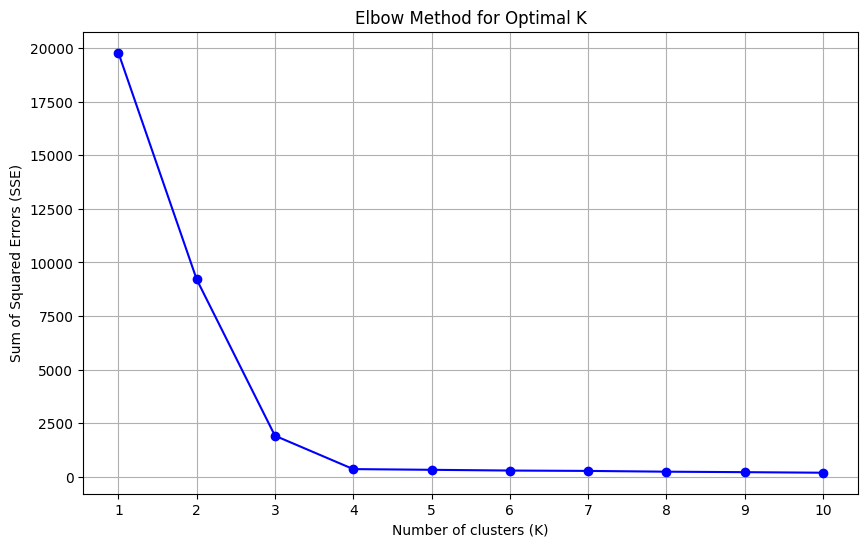

In [8]:
#Problem 8

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

def elbow_method(X, max_k=10, n_init=10, random_state=None):
    """
    Perform the elbow method to determine optimal number of clusters
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        Input data
    max_k : int
        Maximum number of clusters to try
    n_init : int
        Number of initializations for each K-means run
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    k_values : list
        List of tested k values
    sse_values : list
        List of SSE values for each k
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    k_values = range(1, max_k+1)
    sse_values = []
    
    for k in k_values:
        # Initialize and fit K-means
        kmeans = ScratchKMeans(n_clusters=k, n_init=n_init, verbose=False)
        kmeans.fit(X)
        
        # Store SSE value
        sse_values.append(kmeans.inertia_)
        
        print(f"K={k}, SSE={kmeans.inertia_:.2f}")
    
    return k_values, sse_values

# Generate sample data
X, _ = make_blobs(n_samples=300, centers=4, random_state=42, cluster_std=0.8)

# Apply elbow method
k_values, sse_values = elbow_method(X, max_k=10, random_state=42)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse_values, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal K')
plt.xticks(k_values)
plt.grid(True)
plt.show()


Analyzing k=2


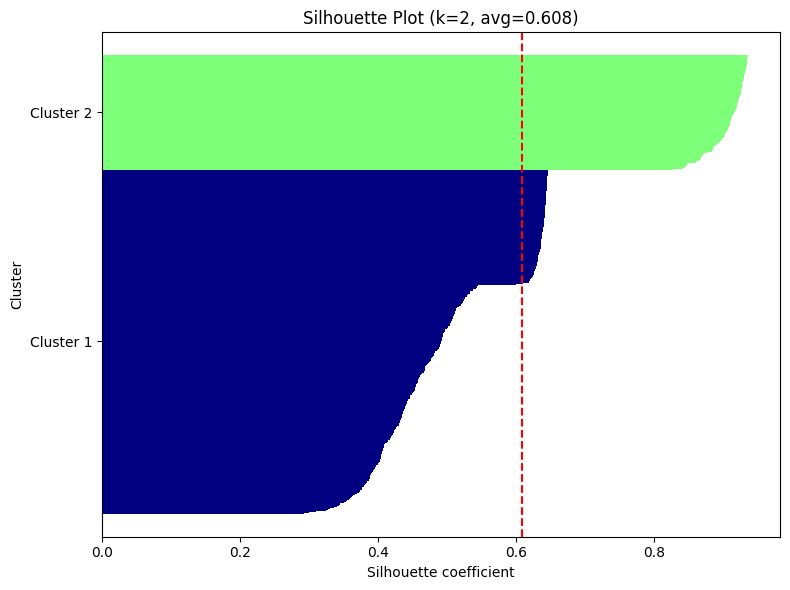


Analyzing k=3


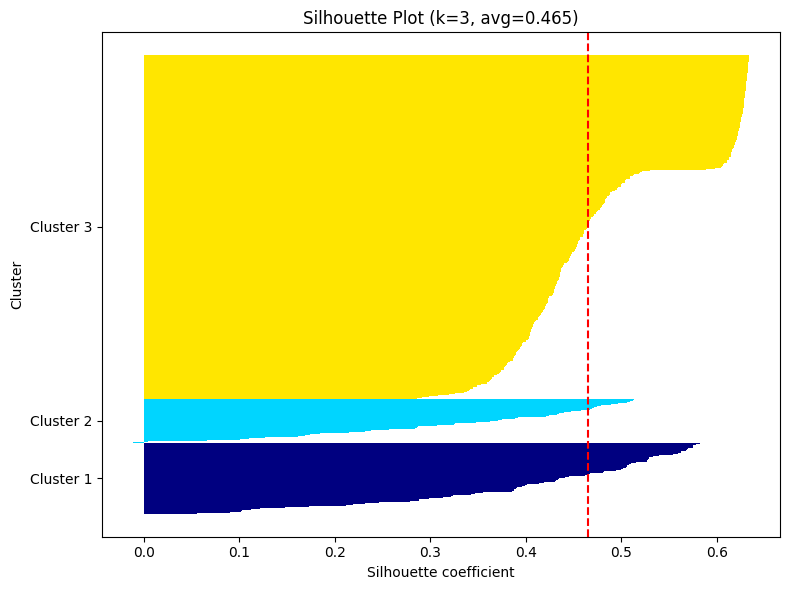


Analyzing k=4


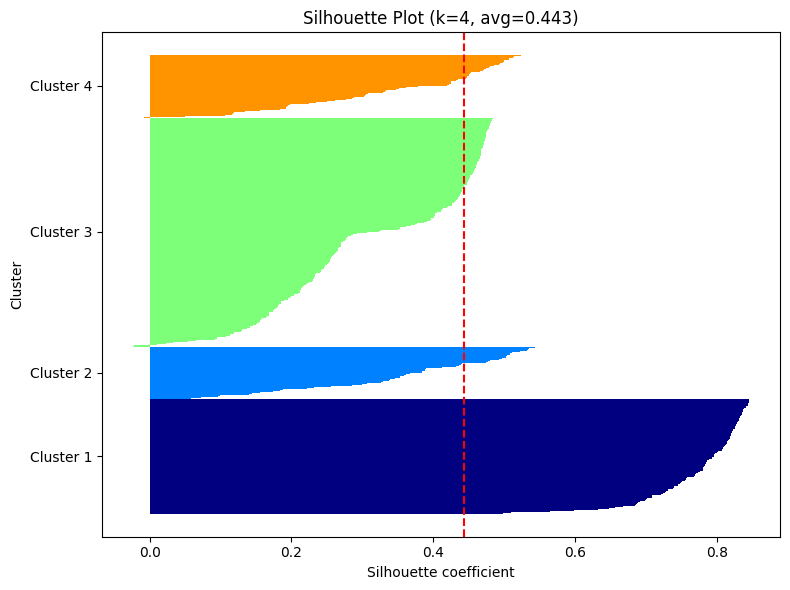


Analyzing k=5


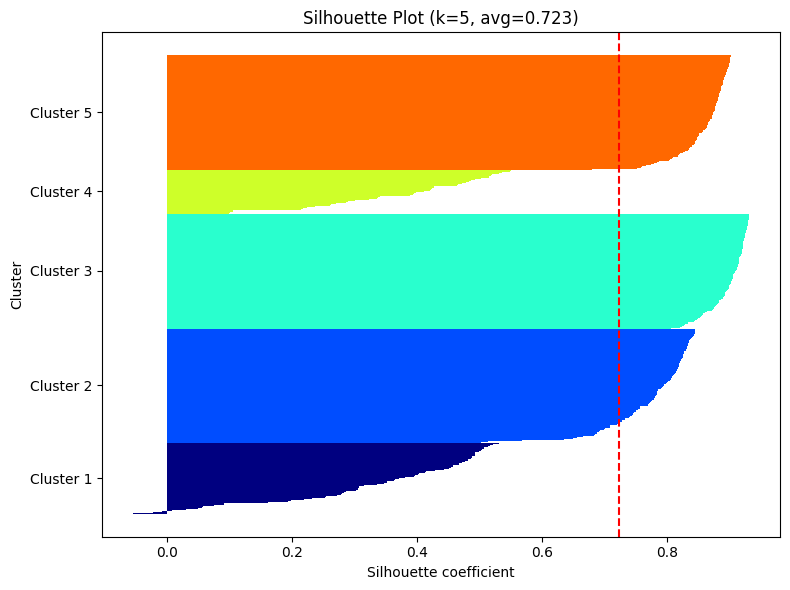

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.datasets import make_blobs

class ScratchKMeans:
    """
    Complete K-means implementation with silhouette analysis
    """
    def __init__(self, n_clusters=8, n_init=10, max_iter=300, tol=1e-4, verbose=False):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None
        self.n_iter_ = 0

    def _initialize_centroids(self, X):
        """Randomly select initial centroids from data points"""
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[indices]

    def _assign_to_clusters(self, X, centroids):
        """Assign each data point to the nearest centroid"""
        distances = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            distances[:, k] = np.linalg.norm(X - centroids[k], axis=1)
        return np.argmin(distances, axis=1)

    def _move_centroids(self, X, labels, current_centroids):
        """Update centroids to be mean of their assigned points"""
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                new_centroids[k] = np.mean(cluster_points, axis=0)
            else:
                new_centroids[k] = current_centroids[k]
        return new_centroids

    def fit(self, X):
        """Train K-means with multiple initializations"""
        best_inertia = np.inf
        best_centroids = None
        best_labels = None
        
        for init in range(self.n_init):
            centroids = self._initialize_centroids(X)
            
            for iteration in range(self.max_iter):
                labels = self._assign_to_clusters(X, centroids)
                new_centroids = self._move_centroids(X, labels, centroids)
                
                if np.max(np.linalg.norm(new_centroids - centroids, axis=1)) < self.tol:
                    break
                    
                centroids = new_centroids
            
            inertia = sum(np.min(np.linalg.norm(X - centroids[label], axis=1)**2) 
                         for label in [self._assign_to_clusters(X, centroids)])
            
            if inertia < best_inertia:
                best_inertia = inertia
                best_centroids = centroids
                best_labels = labels
                self.n_iter_ = iteration + 1
        
        self.cluster_centers_ = best_centroids
        self.labels_ = best_labels
        self.inertia_ = best_inertia
        return self

    def predict(self, X):
        """Predict cluster labels for new data"""
        if self.cluster_centers_ is None:
            raise ValueError("Model not fitted yet")
        return self._assign_to_clusters(X, self.cluster_centers_)

def calculate_silhouette(X, labels, n_clusters):
    """Calculate silhouette coefficients"""
    n_samples = X.shape[0]
    silhouette_vals = np.zeros(n_samples)
    
    # Calculate pairwise distances
    distances = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        distances[i] = np.linalg.norm(X - X[i], axis=1)
    
    for i in range(n_samples):
        cluster_i = labels[i]
        a_i = np.mean(distances[i, labels == cluster_i])
        
        # Find nearest other cluster
        other_clusters = [c for c in range(n_clusters) if c != cluster_i]
        b_i = min(np.mean(distances[i, labels == c]) for c in other_clusters)
        
        silhouette_vals[i] = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) > 0 else 0
    
    return silhouette_vals, np.mean(silhouette_vals)

def plot_silhouette(X, kmeans, n_clusters):
    """Plot silhouette diagram"""
    labels = kmeans.predict(X)
    silhouette_vals, silhouette_avg = calculate_silhouette(X, labels, n_clusters)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    
    for i in range(n_clusters):
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        y_ax_upper += len(cluster_silhouette_vals)
        
        color = cm.jet(float(i) / n_clusters)
        ax.barh(range(y_ax_lower, y_ax_upper),
                cluster_silhouette_vals,
                height=1.0,
                edgecolor='none',
                color=color)
        
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(cluster_silhouette_vals)
    
    ax.axvline(silhouette_avg, color="red", linestyle="--")
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"Cluster {i+1}" for i in range(n_clusters)])
    ax.set_ylabel('Cluster')
    ax.set_xlabel('Silhouette coefficient')
    ax.set_title(f'Silhouette Plot (k={n_clusters}, avg={silhouette_avg:.3f})')
    plt.tight_layout()
    plt.show()

# sample data
X, _ = make_blobs(n_samples=500, centers=4, random_state=42, cluster_std=0.8)

# Test different k values
for k in range(2, 6):
    print(f"\nAnalyzing k={k}")
    kmeans = ScratchKMeans(n_clusters=k, n_init=10)
    kmeans.fit(X)
    plot_silhouette(X, kmeans, k)

   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185


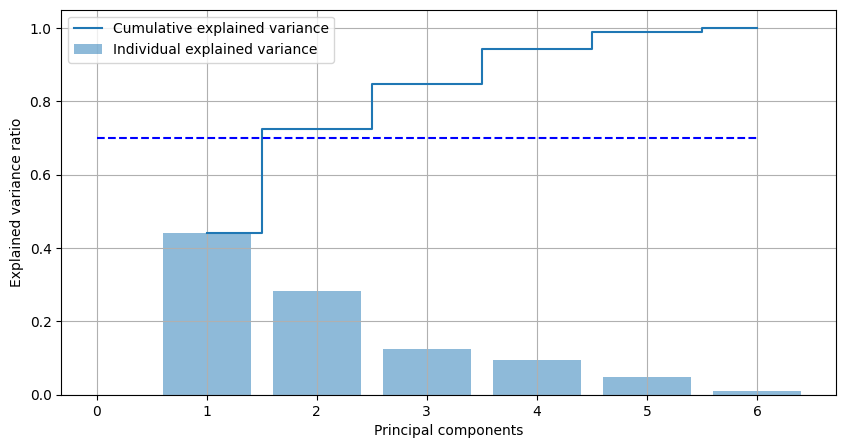

Cumulative explained variance: [0.44082893 0.72459292 0.84793705 0.94189209 0.98950481 1.        ]


c:\Users\Admin\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Admin\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Admin\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Admin\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureW

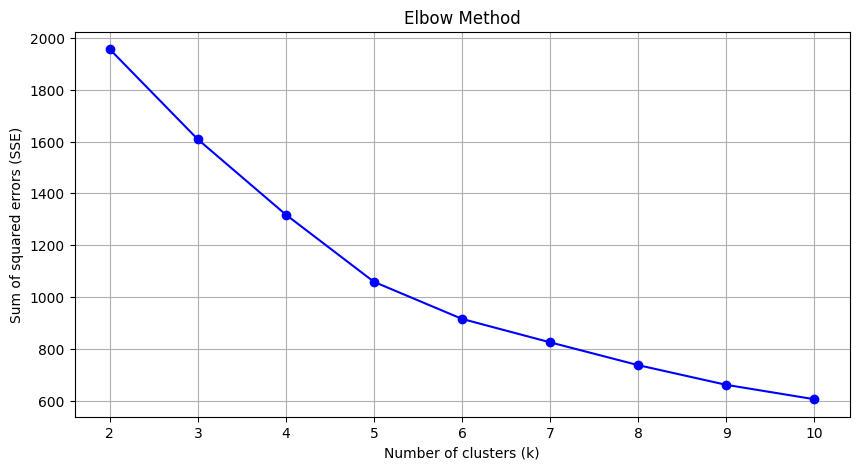

c:\Users\Admin\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


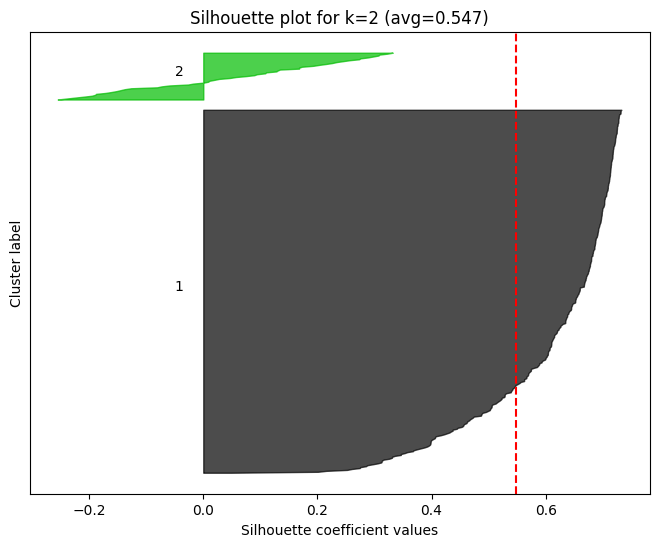

c:\Users\Admin\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


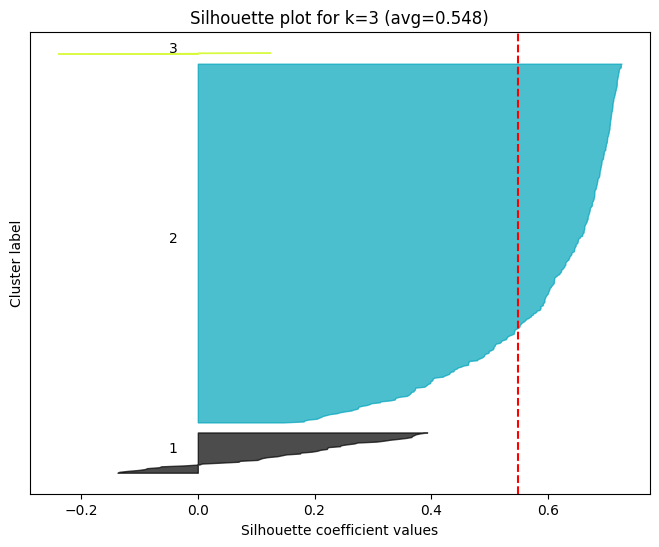

c:\Users\Admin\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


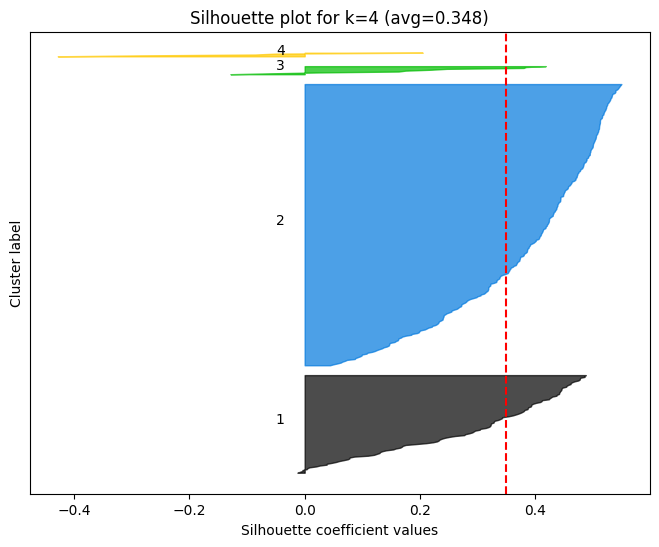

c:\Users\Admin\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


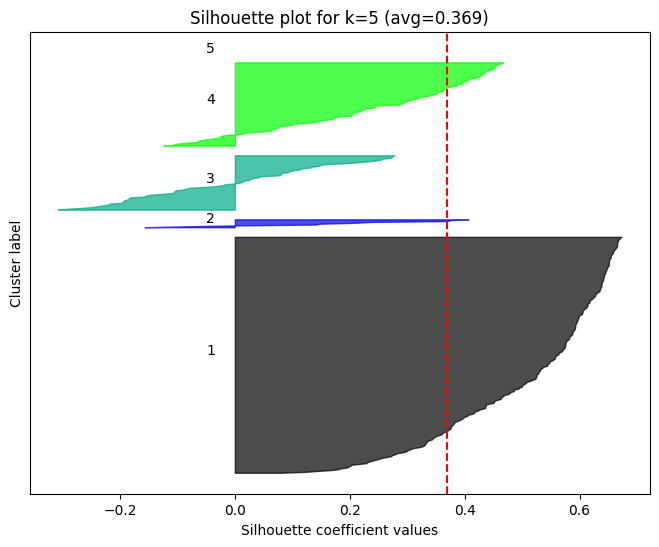

c:\Users\Admin\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


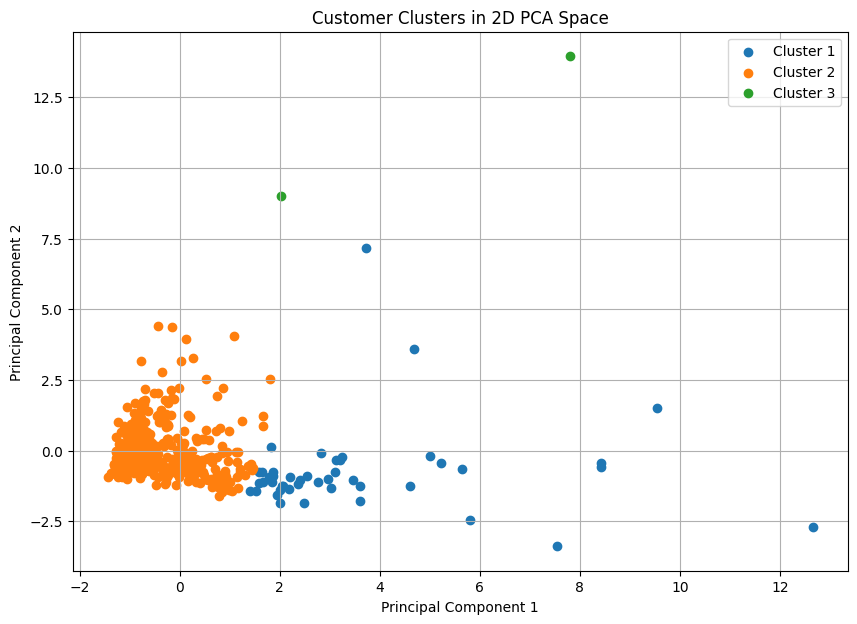

          Channel    Region         Fresh          Milk       Grocery  \
Cluster                                                                 
0        1.977778  2.511111  10440.933333  19386.422222  28656.088889   
1        1.249364  2.547074  12062.913486   4115.099237   5534.966921   
2        1.000000  2.500000  34782.000000  30367.000000  16898.000000   

               Frozen  Detergents_Paper    Delicassen  
Cluster                                                
0         2190.244444      13327.800000   2374.200000  
1         2940.676845       1696.170483   1299.114504  
2        48701.500000        755.500000  26776.000000  


In [ ]:
#Problem 10

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Load the dataset
df = pd.read_csv(r"C:\Users\Admin\Downloads\wholesale+customers.zip")

# Display first few rows
print(df.head())

# Select only the monetary features (excluding Channel and Region)
data = df.iloc[:, 2:]

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)


# Perform PCA for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# variance
pca_full = PCA(n_components=None)
pca_full.fit(data_scaled)
var_exp = pca_full.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(10, 5))
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', 
        label='Individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', 
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6, "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

print("Cumulative explained variance:", cum_var_exp)


# Elbow method
sse = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, sse, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared errors (SSE)')
plt.title('Elbow Method')
plt.grid()
plt.show()

# Silhouette analysis
for k in range(2, 6):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data_scaled)
    
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    sample_silhouette_values = silhouette_samples(data_scaled, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))
        y_lower = y_upper + 10
    
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.set_title(f"Silhouette plot for k={k} (avg={silhouette_avg:.3f})")
    plt.show()


    # Final clustering with k=3
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(data_scaled)

# Add cluster labels to original data
df['Cluster'] = cluster_labels

# Visualize clusters in PCA space
plt.figure(figsize=(10, 7))
for i in range(optimal_k):
    plt.scatter(data_pca[cluster_labels == i, 0], 
                data_pca[cluster_labels == i, 1], 
                label=f'Cluster {i+1}')
    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Customer Clusters in 2D PCA Space')
plt.legend()
plt.grid()
plt.show()

# Analyze cluster characteristics
cluster_means = df.groupby('Cluster').mean()
print(cluster_means)



c:\Users\Admin\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


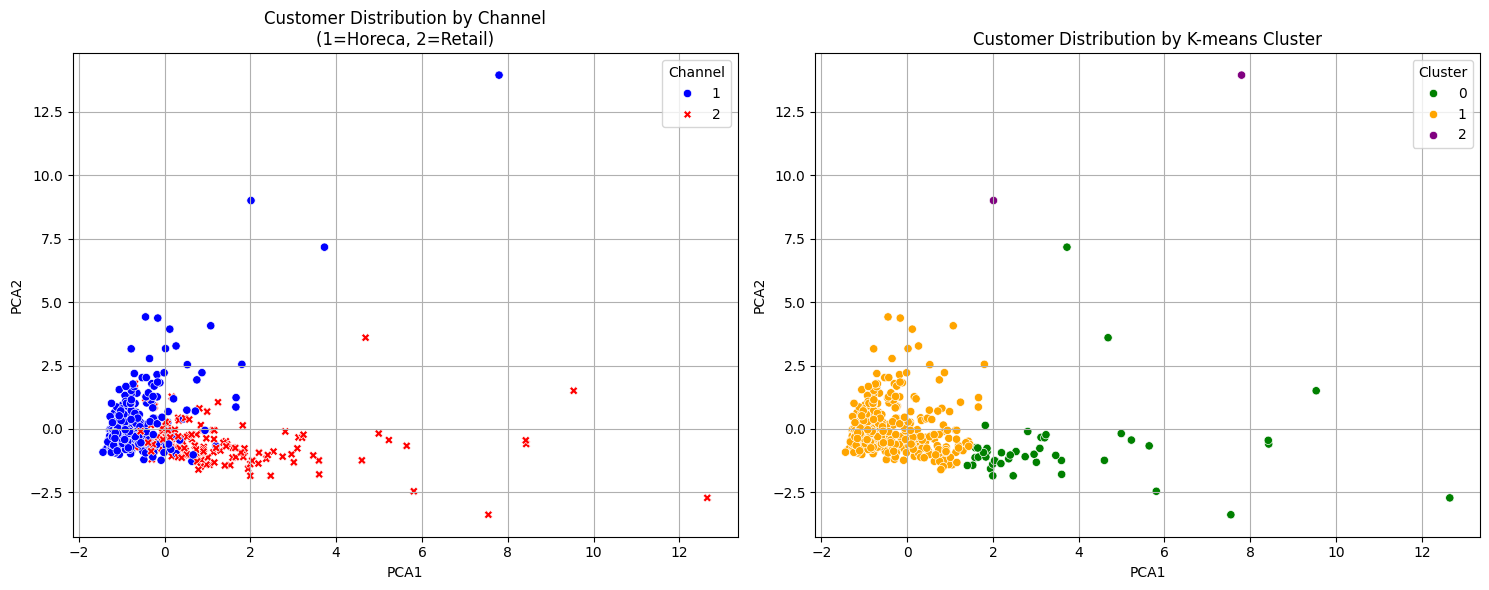

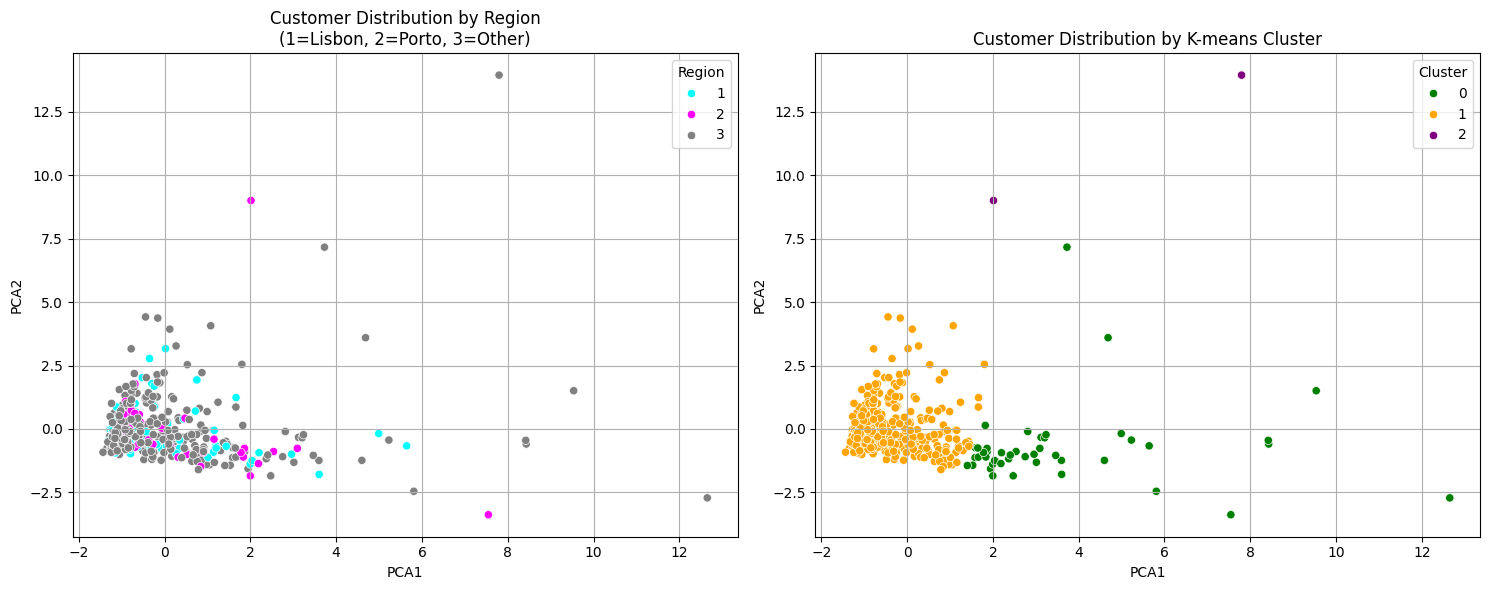


Channel vs Cluster (% distribution):
Cluster          0          1         2
Channel                                
1         0.335570  98.993289  0.671141
2        30.985915  69.014085  0.000000

Region vs Cluster (% distribution):
Cluster          0          1         2
Region                                 
1         9.090909  90.909091  0.000000
2        17.021277  80.851064  2.127660
3         9.493671  90.189873  0.316456


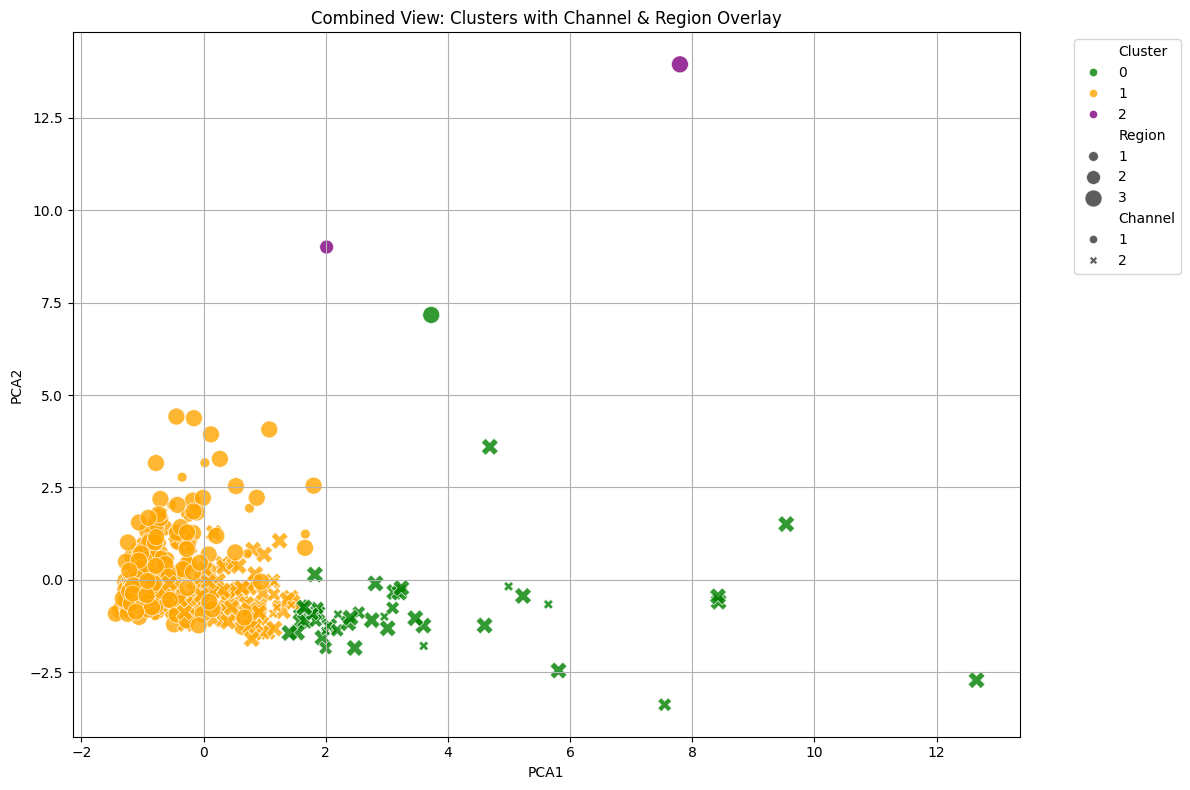

In [ ]:
#problem 11
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the data
df = pd.read_csv(r"C:\Users\Admin\Downloads\wholesale+customers.zip")

# Standardize the monetary features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df.iloc[:, 2:])

# Perform K-means clustering (using k=3 as determined previously)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(data_scaled)

# Reduce dimensions for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
df['PCA1'] = data_pca[:, 0]
df['PCA2'] = data_pca[:, 1]


plt.figure(figsize=(15, 6))

# Plot by Channel (known group)
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Channel', 
                palette=['blue', 'red'], style='Channel')
plt.title('Customer Distribution by Channel\n(1=Horeca, 2=Retail)')
plt.grid()

# Plot by Cluster (our K-means result)
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', 
                palette=['green', 'orange', 'purple'])
plt.title('Customer Distribution by K-means Cluster')
plt.grid()

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))

# Plot by Region (known group)
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Region', 
                palette=['cyan', 'magenta', 'gray'])
plt.title('Customer Distribution by Region\n(1=Lisbon, 2=Porto, 3=Other)')
plt.grid()

# Plot by Cluster (our K-means result)
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', 
                palette=['green', 'orange', 'purple'])
plt.title('Customer Distribution by K-means Cluster')
plt.grid()

plt.tight_layout()
plt.show()

# Channel vs Cluster
channel_cluster = pd.crosstab(df['Channel'], df['Cluster'], 
                             normalize='index') * 100
print("\nChannel vs Cluster (% distribution):")
print(channel_cluster)

# Region vs Cluster
region_cluster = pd.crosstab(df['Region'], df['Cluster'], 
                           normalize='index') * 100
print("\nRegion vs Cluster (% distribution):")
print(region_cluster)


# Create a combined plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='PCA1', y='PCA2', 
                hue='Cluster', style='Channel', size='Region',
                palette=['green', 'orange', 'purple'],
                sizes=(50, 150), alpha=0.8)
plt.title('Combined View: Clusters with Channel & Region Overlay')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [23]:
#problem 12

# Analyze original monetary features by cluster
cluster_summary = df.groupby('Cluster')[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']].mean()
print("Average annual spending by cluster (in monetary units):")
print(cluster_summary)

# Cross-channel analysis
channel_cluster = df.groupby(['Channel', 'Cluster']).size().unstack()
print("\nCustomer distribution across Channels and Clusters:")
print(channel_cluster)

# Regional analysis
region_cluster = df.groupby(['Region', 'Cluster'])['Grocery'].mean().unstack()
print("\nAverage Grocery spending by Region and Cluster:")
print(region_cluster)

Average annual spending by cluster (in monetary units):
                Fresh          Milk       Grocery        Frozen  \
Cluster                                                           
0        10440.933333  19386.422222  28656.088889   2190.244444   
1        12062.913486   4115.099237   5534.966921   2940.676845   
2        34782.000000  30367.000000  16898.000000  48701.500000   

         Detergents_Paper    Delicassen  
Cluster                                  
0            13327.800000   2374.200000  
1             1696.170483   1299.114504  
2              755.500000  26776.000000  

Customer distribution across Channels and Clusters:
Cluster     0      1    2
Channel                  
1         1.0  295.0  2.0
2        44.0   98.0  NaN

Average Grocery spending by Region and Cluster:
Cluster             0            1        2
Region                                     
1        28280.571429  5315.328571      NaN
2        26407.875000  5483.815789  13626.0
3        29343.2

Based on the clustering analysis, I recommend a three-tiered customer approach:

 (1) Volume discounts for Cluster 2's large establishments to maintain their loyalty
 
 (2) Product bundle promotions for Cluster 0's small retailers to increase category penetration
 
 (3) Regional fresh produce initiatives in Porto where Cluster 1 customers show particular strength in perishable categories.

Problem 13

DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

Advantages:

No need to specify number of clusters - Automatically determines clusters based on data density

Handles arbitrary cluster shapes - Can find non-spherical clusters unlike K-means

Robust to outliers - Identifies noise points explicitly

Works well with spatial data - Effective for geospatial and other density-based applications

Single-pass algorithm - Doesn't require multiple iterations like K-means

Disadvantages:

Sensitive to parameter selection - Choice of ε (eps) and min_samples significantly affects results

Struggles with varying densities - Has difficulty when clusters have different densities

Not completely deterministic - Border points may be assigned to different clusters

Performance issues - Can be slow on large datasets (O(n log n) with spatial indexing)

Dimensionality curse - Effectiveness decreases in high-dimensional spaces

t-SNE (t-Distributed Stochastic Neighbor Embedding)

Advantages:

Excellent visualization - Particularly good at preserving local structure in 2D/3D

Captures non-linear relationships - Handles complex manifolds better than linear methods

Emphasizes cluster separation - Makes clusters visually distinct in visualization

Good for high-dimensional data - Effective for visualizing hundreds of dimensions

Disadvantages:

Computationally expensive - O(n²) time complexity makes it slow for large datasets

Non-deterministic - Different runs may produce different results

Perplexity parameter sensitive - Requires careful tuning for good results

Only for visualization - Not typically used for feature extraction

Global structure not preserved - May distort relationships between distant points

LLE (Locally Linear Embedding)

Advantages:

Preserves local geometry - Maintains neighborhood relationships well

Non-linear dimensionality reduction - Can uncover underlying manifold structure

Few parameters - Mainly just the number of neighbors to consider

Good for smooth manifolds - Works well when data lies on smooth lower-dimensional manifold

Computationally efficient - Single optimization problem after neighborhood graph construction

Disadvantages:

Sensitive to neighborhood size - Poor choice of neighbors can lead to bad embeddings

May collapse points - Can sometimes produce degenerate solutions

Poor at handling holes - Struggles with datasets containing "holes" in the manifold

Not good for out-of-sample - Difficult to apply to new points not in original dataset

May fail with sparse data - Requires sufficiently dense sampling of the manifold

c:\Users\Admin\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


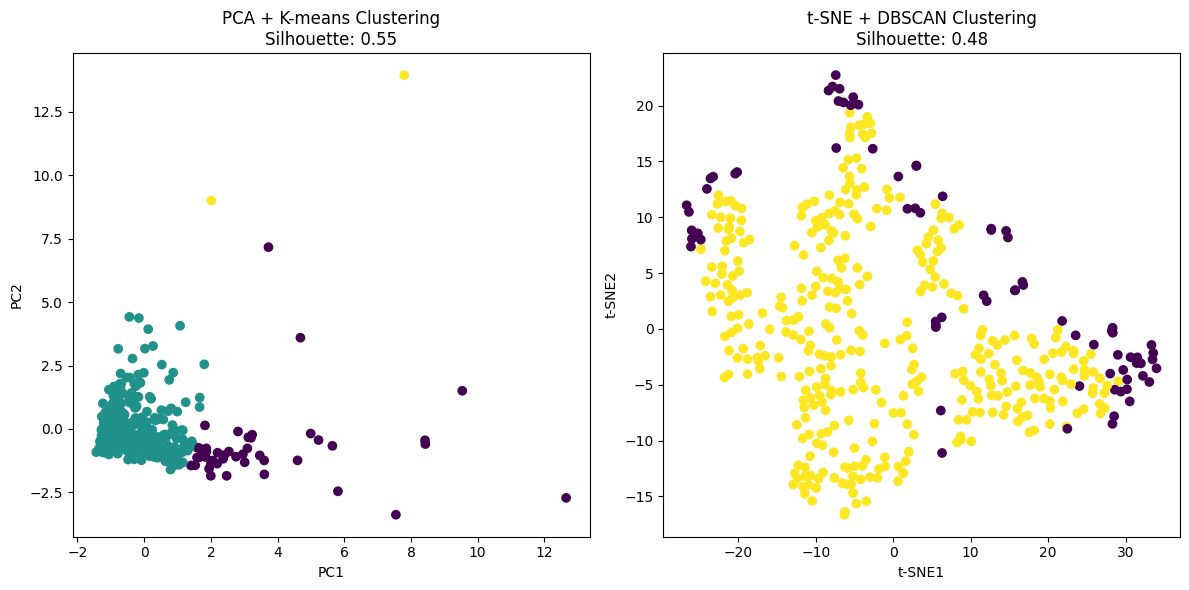


Cluster Counts:
K-means: 0     45
1    393
2      2
Name: count, dtype: int64
DBSCAN: -1     74
 0    366
Name: count, dtype: int64

Channel Distribution:
K-means:
 kmeans_cluster  Channel
0               2          0.977778
                1          0.022222
1               1          0.750636
                2          0.249364
2               1          1.000000
Name: proportion, dtype: float64

DBSCAN:
 dbscan_cluster  Channel
-1              1          0.554054
                2          0.445946
 0              1          0.702186
                2          0.297814
Name: proportion, dtype: float64

Region Distribution:
K-means:
 kmeans_cluster  Region
0               3         0.666667
                2         0.177778
                1         0.155556
1               3         0.725191
                1         0.178117
                2         0.096692
2               2         0.500000
                3         0.500000
Name: proportion, dtype: float64

DBSCAN:
 dbscan_c

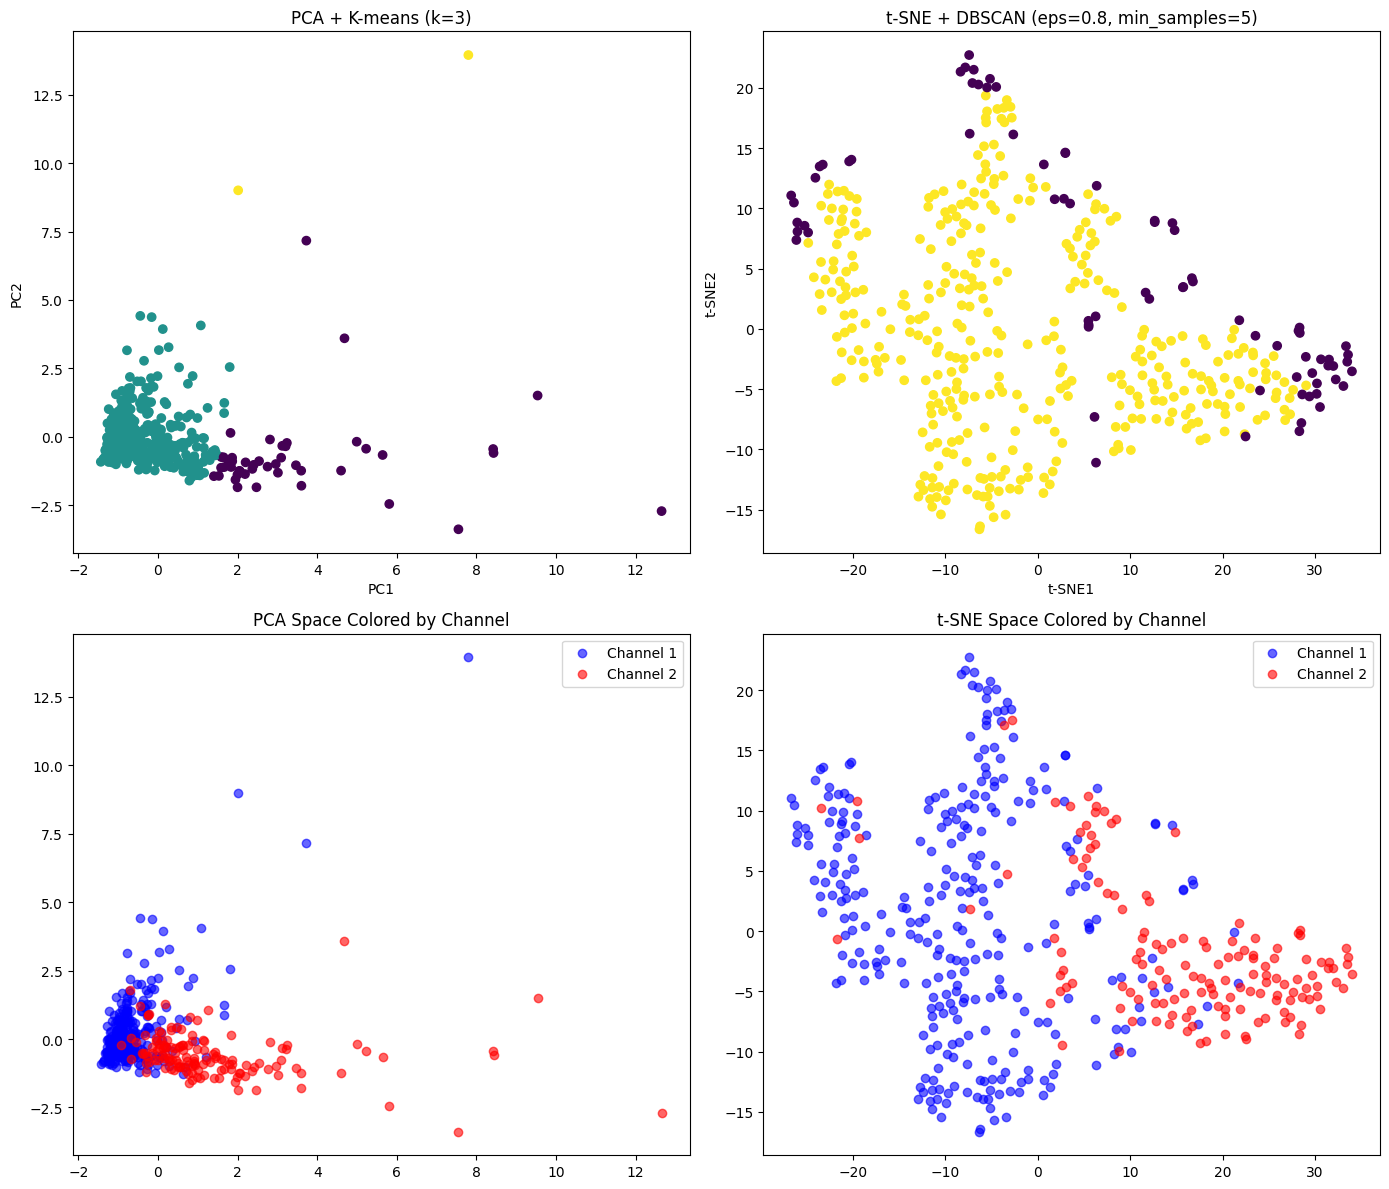

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# Load data
df = pd.read_csv(r"C:\Users\Admin\Downloads\wholesale+customers.zip")
data = df.iloc[:, 2:]  # Monetary features only
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# PCA Dimensionality Reduction
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# K-means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(data_scaled)

# Visualize PCA + K-means
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('PCA + K-means Clustering\nSilhouette: {:.2f}'.format(
    silhouette_score(data_scaled, kmeans_labels)))
plt.xlabel('PC1')
plt.ylabel('PC2')

# Store PCA components for later comparison
df['pca1'] = data_pca[:, 0]
df['pca2'] = data_pca[:, 1]
df['kmeans_cluster'] = kmeans_labels


# t-SNE Dimensionality Reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
data_tsne = tsne.fit_transform(data_scaled)

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.8, min_samples=5)
dbscan_labels = dbscan.fit_predict(data_scaled)

# Visualize t-SNE + DBSCAN
plt.subplot(1, 2, 2)
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('t-SNE + DBSCAN Clustering\nSilhouette: {:.2f}'.format(
    silhouette_score(data_scaled, dbscan_labels)))
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

plt.tight_layout()
plt.show()

# Store t-SNE components and DBSCAN clusters
df['tsne1'] = data_tsne[:, 0]
df['tsne2'] = data_tsne[:, 1]
df['dbscan_cluster'] = dbscan_labels

# Compare cluster characteristics
print("\nCluster Counts:")
print("K-means:", pd.Series(kmeans_labels).value_counts().sort_index())
print("DBSCAN:", pd.Series(dbscan_labels).value_counts().sort_index())

# Compare with known groups
print("\nChannel Distribution:")
print("K-means:\n", df.groupby('kmeans_cluster')['Channel'].value_counts(normalize=True))
print("\nDBSCAN:\n", df.groupby('dbscan_cluster')['Channel'].value_counts(normalize=True))

print("\nRegion Distribution:")
print("K-means:\n", df.groupby('kmeans_cluster')['Region'].value_counts(normalize=True))
print("\nDBSCAN:\n", df.groupby('dbscan_cluster')['Region'].value_counts(normalize=True))


# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# PCA + K-means
axes[0,0].scatter(df['pca1'], df['pca2'], c=df['kmeans_cluster'], cmap='viridis')
axes[0,0].set_title('PCA + K-means (k=3)')
axes[0,0].set_xlabel('PC1')
axes[0,0].set_ylabel('PC2')

# t-SNE + DBSCAN
axes[0,1].scatter(df['tsne1'], df['tsne2'], c=df['dbscan_cluster'], cmap='viridis')
axes[0,1].set_title('t-SNE + DBSCAN (eps=0.8, min_samples=5)')
axes[0,1].set_xlabel('t-SNE1')
axes[0,1].set_ylabel('t-SNE2')

# Channel comparison
for i, (label, color) in enumerate(zip([1,2], ['blue', 'red'])):
    axes[1,0].scatter(df[df['Channel']==label]['pca1'], 
                     df[df['Channel']==label]['pca2'], 
                     color=color, label=f'Channel {label}', alpha=0.6)
axes[1,0].set_title('PCA Space Colored by Channel')
axes[1,0].legend()

for i, (label, color) in enumerate(zip([1,2], ['blue', 'red'])):
    axes[1,1].scatter(df[df['Channel']==label]['tsne1'], 
                     df[df['Channel']==label]['tsne2'], 
                     color=color, label=f'Channel {label}', alpha=0.6)
axes[1,1].set_title('t-SNE Space Colored by Channel')
axes[1,1].legend()

plt.tight_layout()
plt.show()